<a href="https://colab.research.google.com/github/Alyxx-The-Sniper/Deep_learning_sample/blob/main/CNN_PyTorch_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Convolutional Network with PyTorch


## About The Dataset
For this project we will use the Food Images (Food-10) dataset from Kaggle. The dataset contains a number of different subsets of the full food-101 data. 

Food101 has supplied us with metadata for both the test and train sets in a text file. We will make use of this information and extract a portion of it.

`food101 link:` https://www.kaggle.com/datasets/kmader/food41?resource=download&select=food_c101_n1000_r384x384x3.h5


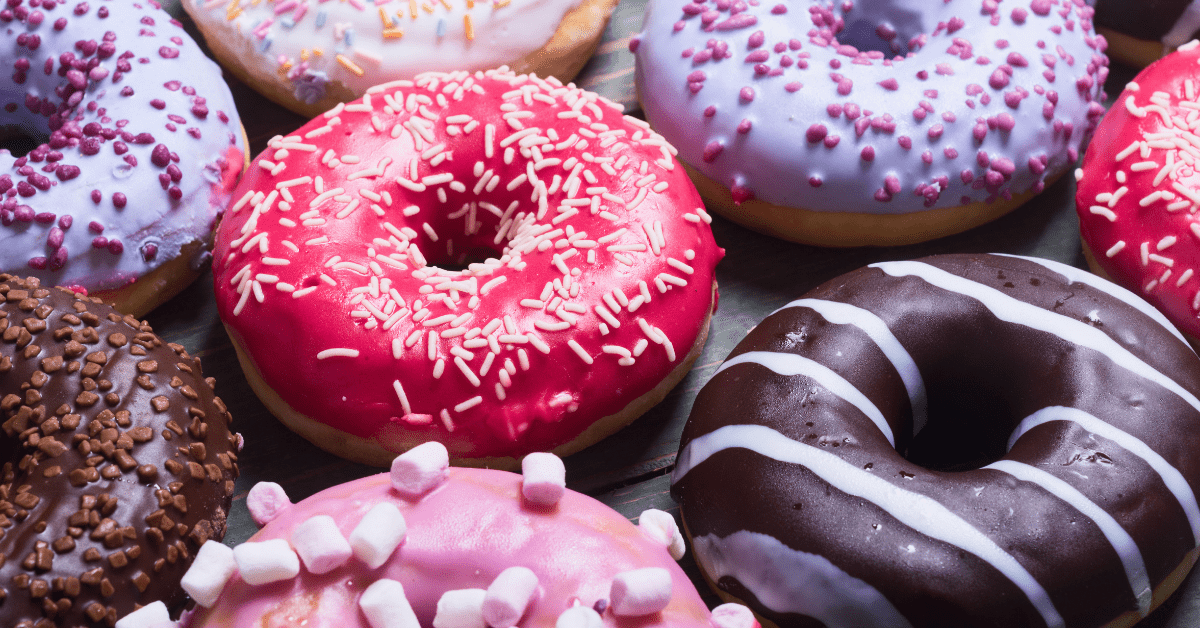

# 1. Get Data

PyTorch offers many built-in data loading functions for handling common types of data. `One useful function is ImageFolder, particularly when working with images in a standard image classification form`

Link: https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#imagefolder

First, the data is downloaded from Kaggle (referring to the provided link) and saved to the Google Drive. Next, a portion of the data, approximately 10% of the total(train and test), is extracted to build the model with a smaller size. This allows for faster training time and enables iteration on the model until satisfaction is achieved. It is important to remember that machine learning is an iterative process, so starting small is recommended. Once the desired performance is achieved, the model can then be scaled up as needed.

Our extracted dataset should be arranged in this format (standard image classification form):

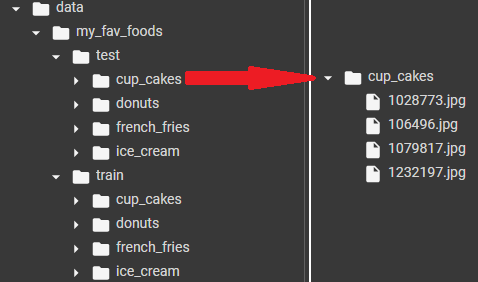

> The goal will be to take this data storage structure and turn it into a dataset usable with PyTorch.


First, let's retrieve my helper functions from my Google Drive.

In [ ]:
import shutil
from shutil import copy

# Specify the source and destination paths
source_file_path = "/content/drive/MyDrive/Deep_learning/helper_functions.py"
destination_file_path = "helper_functions.py"
# Copy the file
copy(source_file_path, destination_file_path)
# Print a success message
print("File copied successfully!")

# importing my helper_fucntions
from helper_functions import download_data_V2, walk_through_dir, plot_transformed_random_images, accuracy_fn, eval_model

File copied successfully!



Below function retrieves a 10% sample of images for each of my favorite foods: cup cakes, donuts, french fries, and ice cream. It fetches the samples from a designated folder in Google Drive and stores them in newly created "train" and "test" folders. The folder structure follows the standard format required by PyTorch's `ImageFolder` dataset.


In [ ]:
# test data
download_data_V2('/content/drive/MyDrive/Deep_learning/data2/meta/meta/test.txt',
                 '/content/drive/MyDrive/Deep_learning/data2/images',
                 'data/my_fav_foods/test',
                 percentage=0.1,
                 class_list=['cup_cakes', 'donuts', 'french_fries', 'ice_cream'])
# train data
download_data_V2('/content/drive/MyDrive/Deep_learning/data2/meta/meta/train.txt',
                 '/content/drive/MyDrive/Deep_learning/data2/images',
                 'data/my_fav_foods/train',
                 percentage=0.1,
                 class_list=['cup_cakes', 'donuts', 'french_fries', 'ice_cream'])

  cup_cakes    donuts    french_fries    ice_cream    cup_cakes    donuts    french_fries    ice_cream  

Check the folder structure

In [ ]:
from pathlib import Path

# data preparation
# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "my_fav_foods"

# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

# check data folder structure
walk_through_dir(data_path)

There are 1 directories and 0 images in 'data'.
There are 2 directories and 0 images in 'data/my_fav_foods'.
There are 4 directories and 0 images in 'data/my_fav_foods/train'.
There are 0 directories and 75 images in 'data/my_fav_foods/train/ice_cream'.
There are 0 directories and 75 images in 'data/my_fav_foods/train/french_fries'.
There are 0 directories and 75 images in 'data/my_fav_foods/train/cup_cakes'.
There are 0 directories and 75 images in 'data/my_fav_foods/train/donuts'.
There are 4 directories and 0 images in 'data/my_fav_foods/test'.
There are 0 directories and 25 images in 'data/my_fav_foods/test/ice_cream'.
There are 0 directories and 25 images in 'data/my_fav_foods/test/french_fries'.
There are 0 directories and 25 images in 'data/my_fav_foods/test/cup_cakes'.
There are 0 directories and 25 images in 'data/my_fav_foods/test/donuts'.


# 2. Data Exploration 
Become one with the data!

Now that we got our dataset, let's explore them.
- Random visualization using PIL



image path: data/my_fav_foods/test/french_fries/457709.jpg
image class: french_fries
image height: 384
image width: 512


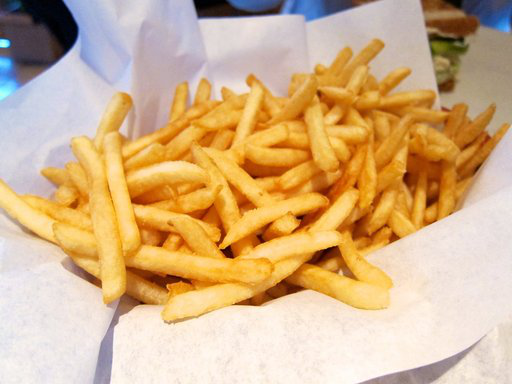

In [ ]:
from PIL import Image
import random
random.seed(42)
# get all image path
all_image_pathlist = list(image_path.glob('*/*/*.jpg'))
# pick a random image from all_image_pathlist 
random_image = random.choice(all_image_pathlist)
# get the image class(the image class is the directory name where the image is stored)
image_class = random_image.parent.stem
# open image using PIL
img = Image.open(random_image)
# print metadata
print(f'image path: {random_image}')
print(f'image class: {image_class}')
print(f'image height: {img.height}')
print(f'image width: {img.width}')
img

# 3. Transforming Data To Tensors
To prepare our image data for deep learning with PyTorch, we follow these key steps:

- Transform images into tensors using `torchvision.transforms`: This converts image data into numerical tensors, enabling machine learning algorithms to process the data. We can also apply data augmentation techniques during this transformation to enhance model performance.

- Convert transformed data into `torch.utils.data.Dataset.ImageFolder`: This format, specific to PyTorch, simplifies handling and organization of the data. It automatically organizes images into class-specific folders for easy access during training.

- Create a `torch.utils.data.DataLoader`: This loader generates batches of samples from the dataset, improving training efficiency by processing multiple samples simultaneously. It speeds up training and enhances model performance.

### 3.1 torchvision.transforms
torchvision.transforms contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for data augmentation.



> Note: We usually don't perform data manipulation on the test set. However, we do need to make sure our test set images are transformed to tensors. We size the test images to the same size as our training images too.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# transform for train
data_transform_train = transforms.Compose([
    # resize to 64x64 just like in tinyVGG architecture (For faster training time)
    transforms.Resize(size=(64,64)),
    # flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # trivial augmentation
    # transforms.TrivialAugmentWide(num_magnitude_bins=5),
    # turn image into a torch.Tensor
    transforms.ToTensor()
])

# transform for test
# dont need to perform
data_transform_test = transforms.Compose([
    # resize to 64x64 just like in tinyVGG architecture (For faster training time)
    transforms.Resize(size=(64,64)),
    # turn image into a torch.Tensor
    transforms.ToTensor()
])

> `NOTE:`
After transforming our image data, it's shape will become color channel first format. (CHW) This arrangement is commonly used in PyTorch.

In [ ]:
# the img shape after transform
print(data_transform_train(img).shape)

torch.Size([3, 64, 64])


To visualize our transformed image using matplotlib, we need to rearrange the shape of the image to follow the format where the color channel is last(HWC). This can be done using the permute method. Matlotlib accept HWC format.

(-0.5, 63.5, 63.5, -0.5)

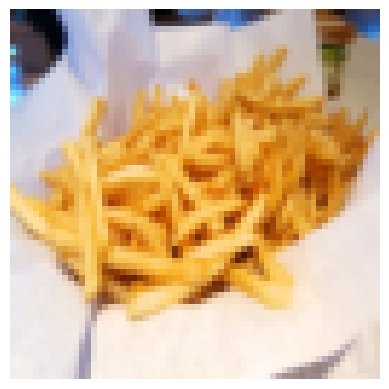

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(data_transform_train(img).permute(1,2,0)) 
plt.axis(False)

Now we've got a composition of transforms, let's call our function to try them out on various images.



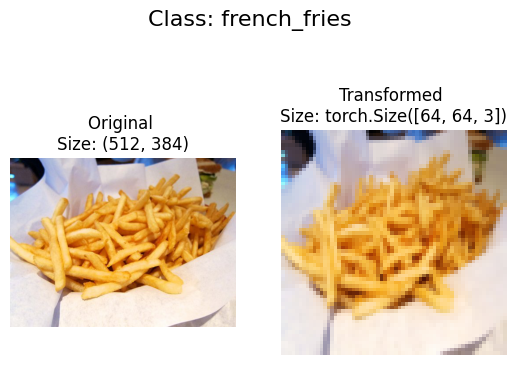

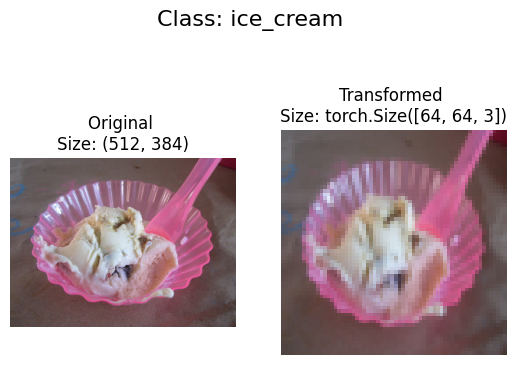

In [ ]:
# NOTE: This function use matlotlib and has permuted the shape of each image for visulalization
# originaly the shape after transform is in CHW format
plot_transformed_random_images(all_image_pathlist, 
                        transform=data_transform_train, 
                        n=2)

### 3.2 torch.utils.data.Dataset.ImageFolder 
Now, it's time to convert our image data into a PyTorch-compatible Dataset. Since our data follows the standard image classification format, we can utilize the torchvision.datasets.ImageFolder class.

By providing the file path of the target image directory and specifying the desired transforms, we can easily use this class. Let's apply it to our train_dir and test_dir data folders, and make use of the transform=data_transform parameter to convert the images into tensors.

In [ ]:
from torchvision import datasets
# use train_data_transform
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform_train, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)
# use test_data_transform
test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform_test)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 300
    Root location: data/my_fav_foods/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 100
    Root location: data/my_fav_foods/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


Investigating and retrieving the most prevalent attributes of our transformed dataset.

In [ ]:
# Check the lengths
print(len(train_data), len(test_data))

# Get class names as a list
class_names = train_data.classes
print(class_names)

# Can also get class names as a dict
class_dict = train_data.class_to_idx
print(class_dict)

300 100
['cup_cakes', 'donuts', 'french_fries', 'ice_cream']
{'cup_cakes': 0, 'donuts': 1, 'french_fries': 2, 'ice_cream': 3}


Inspecting the first image metadata

In [ ]:
img, label = train_data[0][0], train_data[0][1] # indexing the first img and label
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.3216, 0.2314, 0.1647,  ..., 0.9020, 0.9059, 0.9059],
         [0.5647, 0.5373, 0.4471,  ..., 0.4353, 0.4471, 0.4471],
         [0.5216, 0.5608, 0.6039,  ..., 0.6275, 0.6275, 0.6235],
         ...,
         [0.5255, 0.5255, 0.5216,  ..., 0.4784, 0.4588, 0.4510],
         [0.5098, 0.5098, 0.5059,  ..., 0.4667, 0.4510, 0.4353],
         [0.4941, 0.4980, 0.4941,  ..., 0.4471, 0.4314, 0.4196]],

        [[0.3020, 0.2196, 0.1608,  ..., 0.9569, 0.9608, 0.9608],
         [0.5412, 0.4941, 0.4235,  ..., 0.6353, 0.6471, 0.6431],
         [0.5176, 0.5451, 0.5843,  ..., 0.8000, 0.8000, 0.7961],
         ...,
         [0.4000, 0.3961, 0.3922,  ..., 0.3451, 0.3255, 0.3176],
         [0.3765, 0.3765, 0.3725,  ..., 0.3294, 0.3137, 0.3020],
         [0.3608, 0.3647, 0.3608,  ..., 0.3098, 0.2941, 0.2863]],

        [[0.2431, 0.1647, 0.1098,  ..., 0.9725, 0.9725, 0.9725],
         [0.4549, 0.4196, 0.3451,  ..., 0.8745, 0.8863, 0.8863],
         [0.4667, 0.4863, 0.4784,  ..., 0.94

Visualize in Matplotlib

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


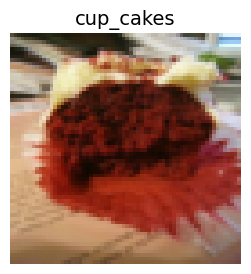

In [ ]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(5, 3))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14);

## 3.3 torch.utils.data.DataLoader
Turning our Dataset's into DataLoader's makes them iterable (in batches) so a model can go through learn the relationships between samples and targets.

In [ ]:
import multiprocessing
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

BATCHSIZE = 32
NUM_WORKERS = multiprocessing.cpu_count()

train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCHSIZE, # how many samples per batch?
                              num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCHSIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f77890772e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f77890768f0>)

 Check the shape

In [ ]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])




---




# 4. Model_0 (Base Model)

In neural networks, building a base model is crucial for architecture exploration, hyperparameter tuning, leveraging pretraining or transfer learning, detecting overfitting, and comparing/selecting models. It serves as a starting point to build more advanced and optimized neural network models.

## 4.1 Building Model Architecture Copying TinyVGG

In [ ]:
from torch import nn
class tinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        # Convolutional blocks 1
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # compresses our images i.e 60x60 image pass through maxpol kernel:2 = 30x30 shape, for kernel of 4 = 15x15 shape
        )

        # Convolutional blocks 2
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13, # each layer of our network compresses and changes the shape of our inputs data
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.block_1(x)
        # print(f'shape after convolutional block 1: {x.shape}')
        x = self.block_2(x)
        # print(f'shape after convolutional block 2: {x.shape}')
        x = self.classifier(x)
        # print(f'shape after classifier: {x.shape}')
        return x

Create an instance of the model

In [ ]:
model_0 = tinyVGG(input_shape=3, 
                  hidden_units=10,
                  output_shape=len(class_names))

Models General Information

In [ ]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=[3, 3, 64, 64]) # do a test pass through of an example input size 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
tinyVGG                                  [3, 4]                    --
├─Sequential: 1-1                        [3, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [3, 10, 62, 62]           280
│    └─ReLU: 2-2                         [3, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [3, 10, 60, 60]           910
│    └─ReLU: 2-4                         [3, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [3, 10, 30, 30]           --
├─Sequential: 1-2                        [3, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [3, 10, 28, 28]           910
│    └─ReLU: 2-7                         [3, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [3, 10, 26, 26]           910
│    └─ReLU: 2-9                         [3, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [3, 10, 13, 13]           --
├─Sequentia

Setup loss function and optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

We will need our helper function again for the training phase and visualizing the performance of the model.

In [ ]:
from helper_functions import train_step, test_step, train, plot_loss_curves, pred_and_plot_image, eval_model, plot_model_performance

Training start here...

In [ ]:
### START TRAINING ###

# Set random seeds
torch.manual_seed(42)

NUM_EPOCHS = 10
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3925 | train_acc: 0.2135 | test_loss: 1.3833 | test_acc: 0.1953
Epoch: 2 | train_loss: 1.3871 | train_acc: 0.2177 | test_loss: 1.3881 | test_acc: 0.1953
Epoch: 3 | train_loss: 1.3849 | train_acc: 0.2573 | test_loss: 1.3892 | test_acc: 0.2109
Epoch: 4 | train_loss: 1.3787 | train_acc: 0.2917 | test_loss: 1.3749 | test_acc: 0.2266
Epoch: 5 | train_loss: 1.3613 | train_acc: 0.3042 | test_loss: 1.3433 | test_acc: 0.3047
Epoch: 6 | train_loss: 1.3281 | train_acc: 0.3240 | test_loss: 1.3062 | test_acc: 0.3984
Epoch: 7 | train_loss: 1.2638 | train_acc: 0.3688 | test_loss: 1.3065 | test_acc: 0.2734
Epoch: 8 | train_loss: 1.2820 | train_acc: 0.4177 | test_loss: 1.3819 | test_acc: 0.3359
Epoch: 9 | train_loss: 1.2382 | train_acc: 0.4115 | test_loss: 1.2895 | test_acc: 0.4531
Epoch: 10 | train_loss: 1.2301 | train_acc: 0.4365 | test_loss: 1.3412 | test_acc: 0.3828
Total training time: 50.883 seconds


In [ ]:
print(model_0_results.keys())
model_0_results['test_acc'][-1]

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])


0.3828125

Visualize model_0 performance

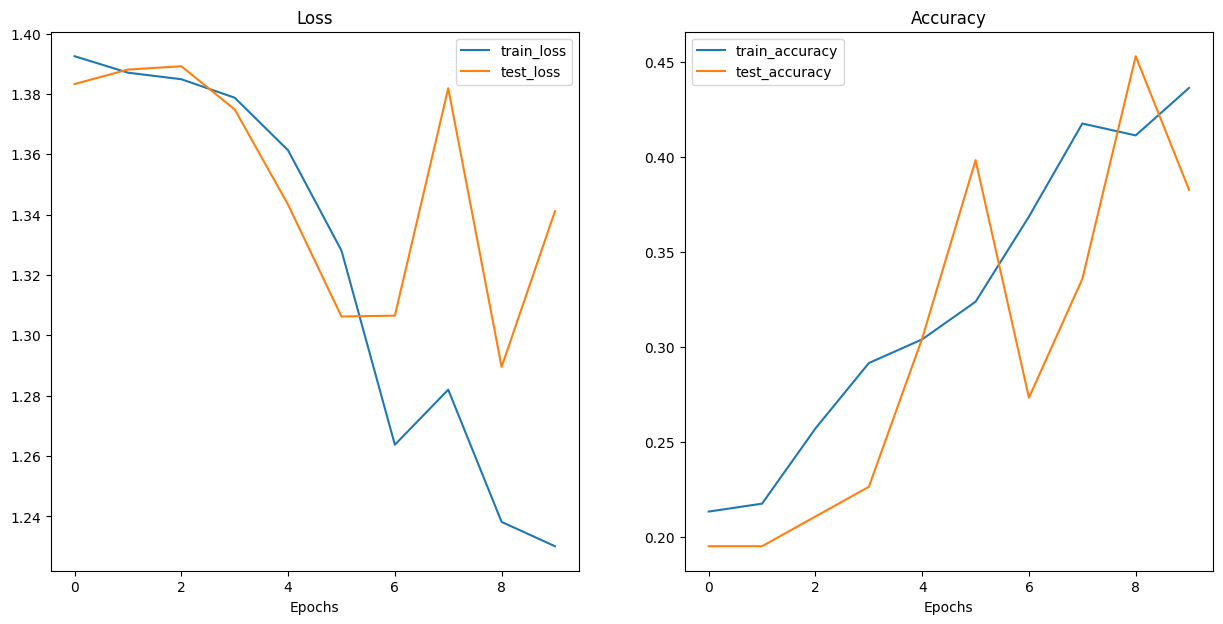

In [ ]:
plot_loss_curves(model_0_results)



Based on the given model settings and hyperparameters, it seems that model_0 is not achieving satisfactory accuracy. The visualization of the performance indicates that the model performs well on the training data but significantly worse on the testing data, suggesting a clear case of overfitting due to a noticeable gap between the training and testing loss.

We can refer to the following link for guidance on resolving the issue: https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html.
 
 Additionally we can:
>Increasing the number of epochs based on the graph's trend indicates potential for improvement. Also, we can experiment transforming the input size (e.g., upscaling from 64x64), although it may require longer training time. Gathering more samples for the neural network can also lead to better results.

Here are some common hyperparameters used in PyTorch:

1. Learning Rate: Determines the step size for updating model weights during training.
2. Batch Size: The number of samples processed in each iteration during training.
3. Number of Epochs: The total times the entire dataset is passed through the model during training.
4. Loss Function: Calculates the error between predicted and target values.
5. Optimizer: Algorithm used to update model weights based on the calculated loss.
6. Momentum: A parameter that accumulates a fraction of past gradients to accelerate convergence.
7. Weight Decay: Regularization term that penalizes large weights to prevent overfitting.
8. Dropout: A regularization technique randomly dropping a fraction of neural network units during training.
9. Activation Function: Non-linear function applied to the output of a neural network layer.
10. Hidden Layer Sizes: The number of neurons in each hidden layer of a neural network.
11. kernel_size, stride, and padding

These hyperparameters significantly influence the model's performance and training in PyTorch. Properly tuning them is crucial for achieving optimal results.



## 4.2 The balance between overfitting and underfitting
None of the methods discussed above are silver bullets, meaning, they don't always work.

And preventing overfitting and underfitting is possibly the most active area of machine learning research.

Since everone wants their models to fit better (less underfitting) but not so good they don't generalize well and perform in the real world (less overfitting).

There's a fine line between overfitting and underfitting.

Because too much of each can cause the other.

Transfer learning is perhaps one of the most powerful techniques when it comes to dealing with both overfitting and underfitting on your own problems.

# 5. Improving our Model (*Model_V1*)
Now that we have obtained results from our base model and identified overfitting, we plan to improve our model (model_V1) by incorporating trivial augmentation techniques.

## 5.1 TrivialAugmentation
Data augmentation is a technique used to increase the size and diversity of a training dataset. It involves applying transformations to existing data, creating new samples that are similar but slightly different. This helps improve the performance and generalization of machine learning models by exposing them to a larger and more varied set of examples. Common transformations include geometric changes, color adjustments, distortion, and randomization. Data augmentation is applied during training to prevent overfitting and enhance the model's ability to handle real-world variations.

Here are the proposed changes from the previous model:

1. Apply trivial augmentations
 - With trivial augmentation = 5

By implementing this modifications, we aim to make it harder for the model's understanding of the data while reducing the risk of overfitting.


In [ ]:
data_transform_train_V1 = transforms.Compose([
    # resize to 64x64 just like in tinyVGG architecture
    transforms.Resize(size=(64,64)),
    # flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # trivial augmentation
    transforms.TrivialAugmentWide(num_magnitude_bins=5),
    # turn image into a torch.Tensor
    transforms.ToTensor()
])

data_transform_test_V1 = transforms.Compose([
    # resize to 64x64 just like in tinyVGG architecture
    transforms.Resize(size=(64,64)),
    # turn image into a torch.Tensor
    transforms.ToTensor()
])

In [ ]:
# use data_transform_train_V1 here
train_data_V1 = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform_train_V1, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

# use data_transform_test_V1 here
test_data_V1 = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform_test_V1)

In [ ]:
BATCHSIZE = 32
NUM_WORKERS = multiprocessing.cpu_count()

train_dataloader_V1 = DataLoader(dataset=train_data_V1, 
                              batch_size=BATCHSIZE, # how many samples per batch?
                              num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader_V1 = DataLoader(dataset=test_data_V1, 
                             batch_size=BATCHSIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False) # don't usually need to shuffle testing data

# train_dataloader_V1, test_dataloader_V1

Same architecture as tinyVGG 

In [ ]:
model_V1 = tinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_V1.classes))

In [ ]:
### START TRAINING ###

# Set random seeds
torch.manual_seed(42)

NUM_EPOCHS = 10
from timeit import default_timer as timer 
start_time = timer()

# Train model_1 
model_1_results = train(model=model_V1, 
                        train_dataloader=train_dataloader_V1,
                        test_dataloader=test_dataloader_V1,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3873 | train_acc: 0.2500 | test_loss: 1.3707 | test_acc: 0.4141
Epoch: 2 | train_loss: 1.3887 | train_acc: 0.2396 | test_loss: 1.3707 | test_acc: 0.4141
Epoch: 3 | train_loss: 1.3893 | train_acc: 0.2396 | test_loss: 1.3707 | test_acc: 0.4141
Epoch: 4 | train_loss: 1.3869 | train_acc: 0.2552 | test_loss: 1.3707 | test_acc: 0.4141
Epoch: 5 | train_loss: 1.3877 | train_acc: 0.2500 | test_loss: 1.3707 | test_acc: 0.4141
Epoch: 6 | train_loss: 1.3886 | train_acc: 0.2396 | test_loss: 1.3707 | test_acc: 0.4141
Epoch: 7 | train_loss: 1.3879 | train_acc: 0.2500 | test_loss: 1.3707 | test_acc: 0.4141
Epoch: 8 | train_loss: 1.3873 | train_acc: 0.2500 | test_loss: 1.3707 | test_acc: 0.4141
Epoch: 9 | train_loss: 1.3866 | train_acc: 0.2604 | test_loss: 1.3707 | test_acc: 0.4141
Epoch: 10 | train_loss: 1.3867 | train_acc: 0.2552 | test_loss: 1.3707 | test_acc: 0.4141
Total training time: 51.244 seconds


In [ ]:
model_1_results['test_acc'][-1]

0.4140625

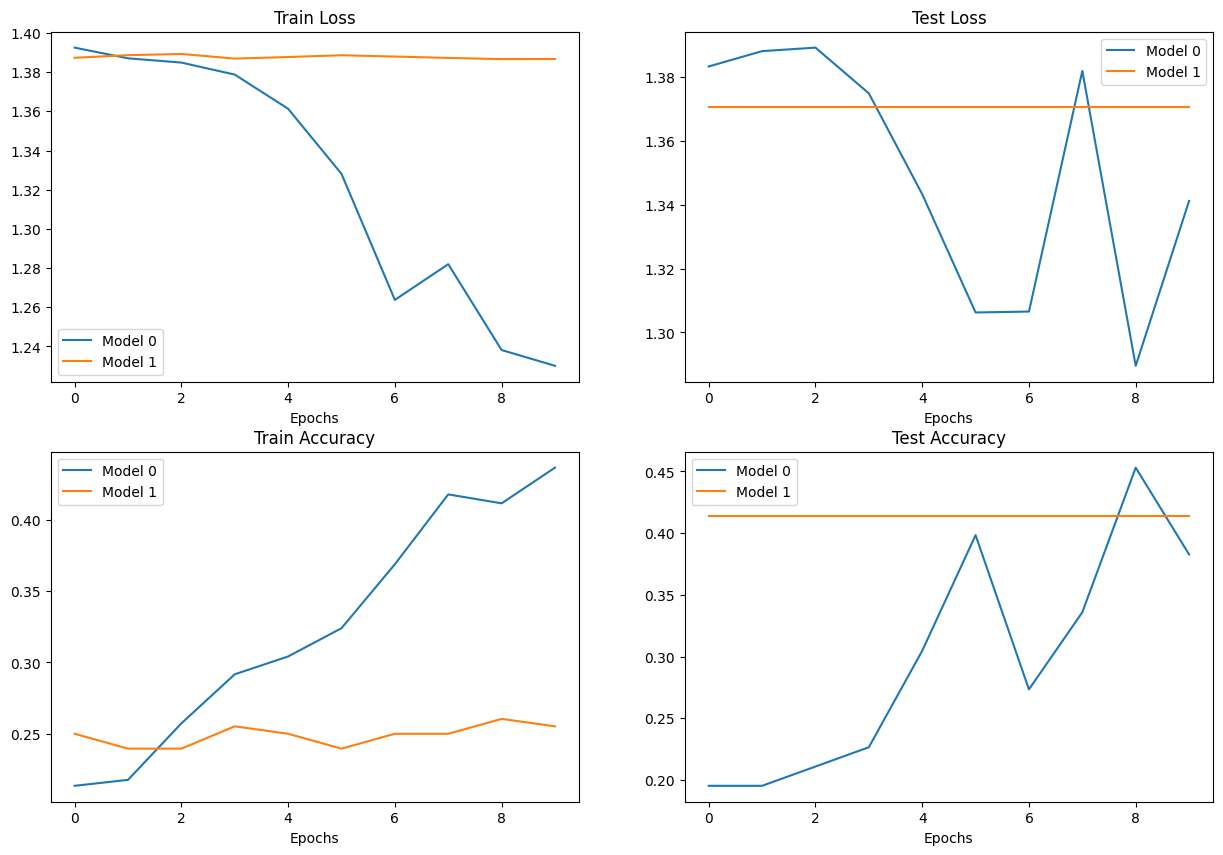

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

plot_model_performance(model_0_df, model_1_df)

The results of model_V1 with TrivialAugmentWide bin of 5 indicate that it struggles to learn from the training data, but performs exceptionally well on the testing data. This suggests that the model has effectively reduced overfitting, as it generalizes better to unseen data.

## 5.2 Confusion Matrix

In [ ]:
# !pip install torchmetrics
# !pip install mlxtend

# from torchmetrics import ConfusionMatrix
# from mlxtend.plotting import plot_confusion_matrix

In [ ]:
from tqdm.auto import tqdm

def conft_matrix(model: torch.nn.Module,
                 dataset: torch.utils.data.dataset.Dataset,
                 dataloader: torch.utils.data.DataLoader,
                 ):


  y_preds = []
  model.eval()
  with torch.inference_mode():
    # evaluate per batch using test_dataloader
    for X_test, y_test in tqdm(dataloader, desc='Making predictions...'):
        
        y_logit = model(X_test)
        y_preds.append(torch.softmax(y_logit, dim=0).argmax(dim=1))



  # convert into i demensional tensor
  y_preds_tensor = torch.concat(y_preds)
  # retreive the truth label
  y_true_tensor = torch.tensor(dataset.targets)

  # create confusion matrix
  cm = ConfusionMatrix(task='multiclass', num_classes=len(class_names))
  cm = cm(y_preds_tensor, y_true_tensor)
  # Convert the confusion matrix to a NumPy array
  cm = cm.numpy()

  # Plot the confusion matrix
  fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True)
  # Set the tick labels on the x and y axes
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  # Show the plot


  return y_preds_tensor,y_true_tensor

Making predictions...:   0%|          | 0/4 [00:00<?, ?it/s]

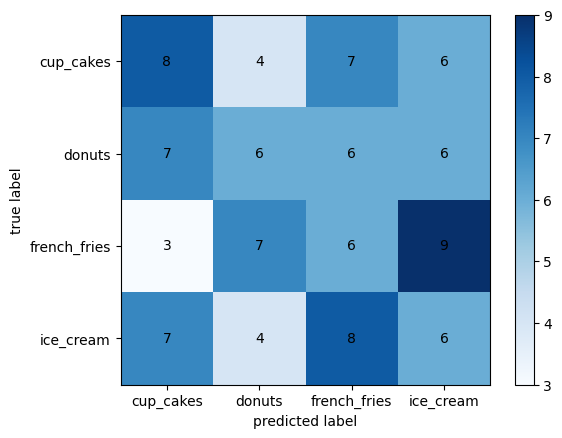

In [ ]:
Confusion_Matrix_V1 = conft_matrix(model_V1,
                      test_data_V1,
                      test_dataloader_V1)

In [ ]:
y_pred, y_true = Confusion_Matrix_V1
y_pred, y_true 

Interpretation:

1. Out of the 100 samples in the test_data, our model made 26 correct predictions.
2. Specifically, it accurately predicted 8 out of 25 cupcakes.
3. It is worth focusing on the instances where the model made significant incorrect predictions. For example, it incorrectly labeled 9 samples as ice cream when their true labels were french fries. This could be due to images that contain both ice cream and french fries, mislabeled sample designs, or other variables at play.

# Make a Prediction on a Custom Image 
>We'll need to convert it to the same format as the data our model is trained on except the augmentation and randomflip.

Copy an image file

In [ ]:
copy('/content/drive/MyDrive/Deep_learning/my_donut.jpg',
     '/content/data')
# Print a success message
print("File copied successfully!")

Visualize the image

In [ ]:
img = Image.open('/content/data/my_donut.jpg')
img

Setup custom image path

In [ ]:
custom_image_path = data_path / "my_donut.jpg"
custom_image_path

 We will read our image using torchvision.io.read_image().

This method will read a JPEG or PNG image and turn it into a 3 dimensional RGB or grayscale torch.Tensor with values of datatype uint8 in range [0, 255].

In [ ]:
import torchvision
# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Our custom_image tensor is of datatype torch.uint8 and its values are between [0, 255].

But our model takes image tensors of datatype torch.float32 and with values between [0, 1].

So before we use our custom image with our model, we'll need to convert it to the same format as the data our model is trained on.

In [ ]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")


Transform our custom image to 64x64

In [ ]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image to 61 x 64 and add batch size of 1 in index 0
custom_image_transformed = custom_image_transform(custom_image).unsqueeze(dim=0)

# add batch size to the shape
custom_image_transformed.shape

Prediction

In [ ]:
custom_image_pred = model_V1(custom_image_transformed)
# results will be in logits form (raw output)
custom_image_pred

Converting from logits -> prediction probabilities -> prediction labels.

In [ ]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f'Class Distionary: {class_dict}')
print(f"Prediction label: {class_names[custom_image_pred_label]}")

Our model wrongly predict donut for ice_cream with a very low probability. Checking the custom_image_pred_probs, we'll notice that the model gives almost equal weight (the values are similar) to every class.

Having prediction probabilities this similar could mean a couple of things:

1. The model is trying to predict all four classes at the same time (there may be an image containing sll the classes).
2. The model doesn't really know what it wants to predict and is in turn just assigning similar values to each of the classes.

Our case is number 2, since our model is poorly trained, it is basically guessing the prediction.

Prediction Function

In [ ]:
pred_and_plot_image(model_V1,
                    custom_image_path,
                    class_names,
                    custom_image_transform)